<a href="https://colab.research.google.com/github/kapitalistka/SberSchoolGroupProject/blob/main/Masloed_attempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/ieee-fraud-detection/

Детекция мошеннических операций. Предсказание мошенничества крайне актуальная задача в современных финансовых организациях. Обратите внимание на несбалансированность классов. Это может стать большой проблемой при решении.


Categorical Features 
- Transaction
- ProductCD
-card1 
- card6
-addr1, addr2
-P_emaildomain
-R_emaildomain
-M1 - M9


Categorical Features 
- Identity
-DeviceType
-DeviceInfo
-id_12 - id_38


The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

## Загружаем данные с Kaggle

In [1]:
#!pip install kaggle
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

drive.mount('/content/gdrive')
pd.options.display.float_format = "{:,.2f}".format


def update_kaggle_token():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

update_kaggle_token()

%cd /
%cd /content
!mkdir -p kaggle/GP2/
%cd kaggle/GP2
!kaggle competitions download -c ieee-fraud-detection
%cd /content


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
/
/content
/content/kaggle/GP2
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
/content


## Загружаем  Train датасет

In [2]:
path = "kaggle/GP2/"
file_train_transactions = "train_transaction.csv"
file_test_transactions = "test_transaction.csv"
file_train_identity = "train_identity.csv"
file_test_identity = "test_identity.csv"

def get_zip_file(path, file_name):
  return path + file_name + ".zip"

def get_big_data_from_zip(path, file_name):
  file = ZipFile(get_zip_file(path, file_name)).open(file_name)
  tp = pd.read_csv(file, iterator=True, chunksize=50_000)
  #tp = pd.read_csv(file, iterator=True, chunksize=10_000, nrows=200_000)

  return pd.concat(tp)

%time raw_train_transactions = get_big_data_from_zip(path, file_train_transactions)

#%time raw_test_transactions = get_big_data_from_zip(path, file_test_transactions)

%time raw_train_identity = get_big_data_from_zip(path, file_train_identity)

#%time raw_test_identity = get_big_data_from_zip(path, file_test_identity)

train = pd.merge(raw_train_transactions, raw_train_identity, how = 'left', on = 'TransactionID')

del raw_train_transactions, raw_train_identity
gc.collect

print(train.shape)

CPU times: user 35 s, sys: 5.5 s, total: 40.5 s
Wall time: 43.7 s
CPU times: user 1.16 s, sys: 37.5 ms, total: 1.2 s
Wall time: 1.25 s
(590540, 434)


In [5]:
 # Выведем список колонок так, чтобы из него было удобно собирать массив
 str = '' 
 for c in train.columns:
   str += f"'{c}', "
 print(str)

'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V8

In [3]:
#Разобьем фичи на разные списки для удобства обработки

target = 'isFraud'
COLS_EXCLUDE = ['TransactionID',  'TransactionDT']

c1 =['TransactionID', 'isFraud', 'TransactionDT',
      'DeviceType', 'DeviceInfo',]#exclude


c_object = ['ProductCD']

c_object_with_na = ['card4', 'card6',  'P_emaildomain', 'R_emaildomain', ]

c_int  = ['card1',]

c_float_to_int_with_na = [ 'card2', 'card3', 'card5', 'addr1', 'addr2',  'dist1', 'dist2', ]

#non nan, float 
# Упс!! !!!! в тестовом дата сете полно нулей
c_float =[ 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
          'TransactionAmt' ]
 
# with nan, float
c_D = [ 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',] 
 
# with nan, object 
c_M = [ 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', ] 


#with  nan, float
c_V = [ 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 
 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 
 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 
] 

#with  nan, float and object ->
c_id =  ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
  'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 
  'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
  ]
##########################
c_float_and_int = c_int + c_float_to_int_with_na + c_float+ c_D + c_V


In [4]:
from sklearn.impute import SimpleImputer

# пока простое избавление от пропущенных значений
def prepare_data(data):

  #################### все столбцы C
  print("C_ columns pocessing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_float])
  data[c_float] = imputer.transform(data[c_float])

  #################### все столбцы V
  print("V_ columns pocessing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_V])
  data[c_V] = imputer.transform(data[c_V])
  data[c_V] = data[c_V].astype(int)


  #################### все столбцы id_
  col_id_float =[]
  col_id_obj =[]

  print("id_ columns pocessing...")
  for col in c_id:
    if data[col].dtype == np.object: col_id_obj.append(col)
    elif data[col].dtype == np.float64: col_id_float.append(col)
    else: print(f'error: {col.dtype}')

  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[col_id_float])
  data[col_id_float] = imputer.transform(data[col_id_float])

  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = "NO_INFO")
  imputer.fit(data[col_id_obj])
  data[col_id_obj] = imputer.transform(data[col_id_obj])

   #################### все столбцы D_
  print("D_ columns pocessing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_D])
  data[c_D] = imputer.transform(data[c_D])

   #################### все столбцы M_
  print("M_ columns pocessing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = "NO_INFO")
  imputer.fit(data[c_M])
  data[c_M] = imputer.transform(data[c_M])

   #################### остальный  object столбцы с na
  print("other object columns pocessing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = "NO_INFO")
  imputer.fit(data[c_object_with_na])
  data[c_object_with_na] = imputer.transform(data[c_object_with_na])

   #################### остальный  float  столбцы с na. которые можно перевести в инт
  print("other float columns pocessing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_float_to_int_with_na])
  data[c_float_to_int_with_na] = imputer.transform(data[c_float_to_int_with_na])
  data[c_float_to_int_with_na] = data[c_float_to_int_with_na].astype(int)

  return data

#train = prepare_data(train)


C_ columns pocessing...
V_ columns pocessing...
id_ columns pocessing...
D_ columns pocessing...
M_ columns pocessing...
other object columns pocessing...
other float columns pocessing...


In [15]:
#Всякие методы, может еще пригодятся
def inf(n):
  print(n)
  print(train[n].describe())
  print(train[n].isna().sum())
  print(train[n].dtype)
  print(train[n].value_counts())

In [ ]:
n = "C1"
inf(n)

In [5]:
str = ""
for col in train.columns:
  if col.startswith("id_") or col.startswith("C") or  col.startswith("D"): str = str+ "'" + col +  "', "
print(str)

'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 


In [5]:

def get_obj_cols(data, with_na):
  col_obj = []
  for col in data.columns:
      dtype = data[col].dtype
      
      if with_na: 
        isWithNa = data[col].isna().sum() > 0
        if dtype == np.object and isWithNa: col_obj.append(col) 

      else:
        if  dtype == np.object: col_obj.append(col) 
  return col_obj


## Разбиваем данные и готовим

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

target = 'isFraud'
y = train[target]
X = train.drop(target, 1)

#'TransactionID', 'isFraud', 'TransactionDT',
X = train.drop('TransactionID', 1)
X = train.drop('TransactionDT', 1)
X = train.drop('DeviceType', 1)
X = train.drop('DeviceInfo', 1)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

del X, y,train, 
gc.collect

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWar

<function gc.collect>

In [7]:
X_train  = prepare_data(X_train)
X_val  = prepare_data(X_val)

C_ columns pocessing...
V_ columns pocessing...
id_ columns pocessing...
D_ columns pocessing...
M_ columns pocessing...
other object columns pocessing...
other float columns pocessing...
C_ columns pocessing...
V_ columns pocessing...
id_ columns pocessing...
D_ columns pocessing...
M_ columns pocessing...
other object columns pocessing...
other float columns pocessing...


## Попытка применения PCA

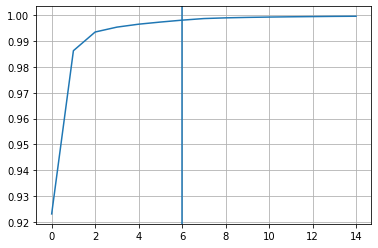

In [9]:
from sklearn.decomposition import PCA
pca = PCA(15)
pca.fit(X_train[c_float_and_int])
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axvline(x=6)
plt.grid()

In [10]:
X_train_pca_part = pca.transform(X_train[c_float_and_int])
X_val_pca_part = pca.transform(X_val[c_float_and_int])

## Попытка применения Catboost

In [34]:
#!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 564 kB 69.4 MB/s 


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier() 
model.fit(X_train_pca_part, y_train) 
y_pred = model.predict(X_val_pca_part) 
print(f"{roc_auc_score(y_pred, y_val)}")
 

In [36]:
print(f"{roc_auc_score(y_pred, y_val)}")


0.8822431613242682


## Загружаем  тестовый датасет

In [ ]:
%time raw_test_transactions = get_big_data_from_zip(path, file_test_transactions)
%time raw_test_identity = get_big_data_from_zip(path, file_test_identity)
test = pd.merge(raw_test_transactions, raw_test_identity, how = 'left', on = 'TransactionID')
X = test
del raw_test_transactions, raw_test_identity, test
gc.collect


In [14]:
del test
gc.collect()

442

In [16]:

Y_ID = X['TransactionID']
X = X.drop('TransactionID', 1)
X = X.drop('TransactionDT', 1)
X = X.drop('DeviceType', 1)
X = X.drop('DeviceInfo', 1)

test_c_id = list(map(lambda c: c.replace("_","-"), c_id))
c_dict = dict(zip(test_c_id, c_id))
X = X.rename(columns = c_dict)

X_test  = prepare_data(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


C_ columns pocessing...
V_ columns pocessing...
id_ columns pocessing...
D_ columns pocessing...
M_ columns pocessing...
other object columns pocessing...
other float columns pocessing...


In [ ]:
X_test_pca_part = pca.transform(X[c_float_and_int])
Y_test_pred = model.predict(X_test_pca_part)
submission = pd.DataFrame(columns=['TransactionID'], data= Y_ID)
submission[target] = Y_test_pred
submission.head()
submission.isFraud.value_counts()

### 3. Загрузка  тестовых значений

In [21]:
submission.to_csv("submission.csv", index = False)

In [22]:
!kaggle competitions submit -c ieee-fraud-detection -f "submission.csv" -m "one more time"

100% 4.83M/4.83M [00:00<00:00, 15.8MB/s]
Successfully submitted to IEEE-CIS Fraud Detection